In [3]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [5]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [6]:
# 📥 Load and preprocess data
df = pd.read_csv("GlobalWeatherRepository.csv")

In [7]:
# 🔍 Overview
print("\n🔎 Dataset Preview:")
print(df.head())

print("\n📏 Dataset Shape:", df.shape)
print("\n📋 Column Info:")
print(df.info())

print("\n🧮 Missing Values:")
print(df.isnull().sum())

print("\n📊 Basic Statistics:")
print(df.describe())



🔎 Dataset Preview:
       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                   

In [8]:
# 👀 Check missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
print("\nColumns with Missing Values:\n", missing)


Columns with Missing Values:
 Series([], dtype: int64)


In [13]:
# 🏷️ Travel Safety Label Function
def assign_travel_safety_label(row):
    if (
        row['visibility_km'] < 2 or
        row['gust_kph'] > 50 or
        row['humidity'] > 90 or
        row['air_quality_PM2.5'] > 75 or
        row['air_quality_us-epa-index'] >= 4
    ):
        return 0
    elif (
        row['visibility_km'] < 5 or
        35 < row['gust_kph'] <= 50 or
        75 < row['humidity'] <= 90 or
        35 < row['air_quality_PM2.5'] <= 75 or
        2 <= row['air_quality_us-epa-index'] < 4
    ):
        return 1
    else:
        return 2

df['travel_safety'] = df.apply(assign_travel_safety_label, axis=1)


In [14]:
# 🎯 Features & Label
features = [
    'temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb', 'precip_mm',
    'cloud', 'visibility_km', 'uv_index', 'gust_kph',
    'air_quality_PM2.5', 'air_quality_us-epa-index'
]
X = df[features]
y = df['travel_safety']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [15]:
# 🔄 Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# 🧱 Dataset Wrapper
class TravelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TravelDataset(X_train_scaled, y_train)
test_dataset = TravelDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [21]:
# 🧠 Model
class TravelNet(nn.Module):
    def __init__(self, input_dim):
        super(TravelNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        return self.model(x)

model = TravelNet(X_train_scaled.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [22]:
# 🏋️ Train
epochs = 50
train_acc_history = []
for epoch in range(epochs):
    model.train()
    correct, total = 0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    acc = correct / total
    train_acc_history.append(acc)
    print(f"Epoch {epoch+1}/{epochs}, Accuracy: {acc:.4f}")

Epoch 1/50, Accuracy: 0.8571
Epoch 2/50, Accuracy: 0.9372
Epoch 3/50, Accuracy: 0.9609
Epoch 4/50, Accuracy: 0.9723
Epoch 6/50, Accuracy: 0.9816
Epoch 7/50, Accuracy: 0.9839
Epoch 8/50, Accuracy: 0.9860
Epoch 9/50, Accuracy: 0.9858
Epoch 10/50, Accuracy: 0.9868
Epoch 11/50, Accuracy: 0.9879
Epoch 12/50, Accuracy: 0.9885
Epoch 13/50, Accuracy: 0.9888
Epoch 14/50, Accuracy: 0.9890
Epoch 15/50, Accuracy: 0.9900
Epoch 16/50, Accuracy: 0.9898
Epoch 17/50, Accuracy: 0.9907
Epoch 18/50, Accuracy: 0.9909
Epoch 19/50, Accuracy: 0.9914
Epoch 20/50, Accuracy: 0.9905
Epoch 21/50, Accuracy: 0.9905
Epoch 22/50, Accuracy: 0.9915
Epoch 23/50, Accuracy: 0.9918
Epoch 24/50, Accuracy: 0.9915
Epoch 25/50, Accuracy: 0.9923
Epoch 26/50, Accuracy: 0.9920
Epoch 27/50, Accuracy: 0.9911
Epoch 28/50, Accuracy: 0.9908
Epoch 29/50, Accuracy: 0.9915
Epoch 30/50, Accuracy: 0.9926
Epoch 31/50, Accuracy: 0.9919
Epoch 32/50, Accuracy: 0.9914
Epoch 33/50, Accuracy: 0.9928
Epoch 34/50, Accuracy: 0.9920
Epoch 35/50, Accur

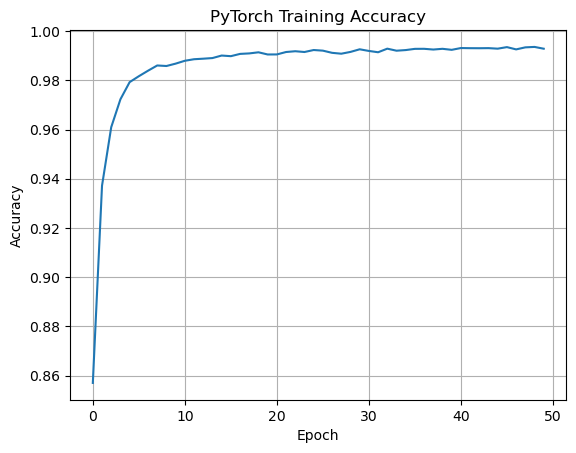

In [25]:
# 📈 Accuracy Plot
plt.plot(train_acc_history)
plt.title("PyTorch Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [27]:
# 🧪 Evaluate
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.tolist())
        all_labels.extend(yb.tolist())

In [29]:
# 📊 Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Unsafe", "Caution", "Safe"]))

Classification Report:
              precision    recall  f1-score   support

      Unsafe       1.00      0.99      1.00      2828
     Caution       0.99      1.00      1.00      6503
        Safe       1.00      0.99      1.00      3376

    accuracy                           1.00     12707
   macro avg       1.00      0.99      1.00     12707
weighted avg       1.00      1.00      1.00     12707



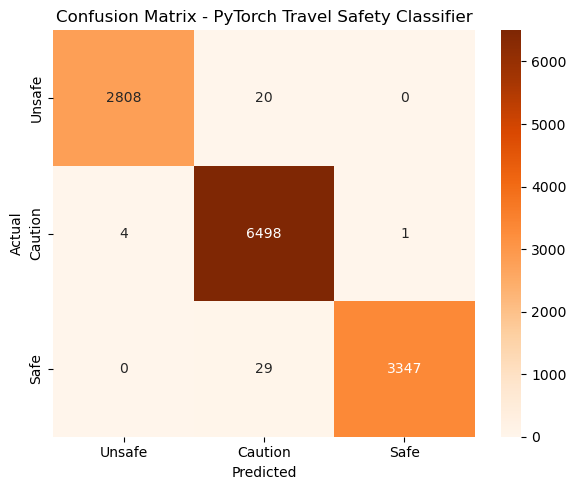

In [31]:
# 📉 Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges',
            xticklabels=["Unsafe", "Caution", "Safe"],
            yticklabels=["Unsafe", "Caution", "Safe"])
plt.title("Confusion Matrix - PyTorch Travel Safety Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [33]:
# 🌍 Dashboard Dataset
label_map = {0: "Unsafe", 1: "Caution", 2: "Safe"}
dashboard_df = df[['country', 'location_name', 'timezone','last_updated', 'travel_safety']].copy()
dashboard_df['travel_safety'] = dashboard_df['travel_safety'].map(label_map)
dashboard_df.to_csv("TravelSafetyDashboard.csv", index=False)
print("\n✅ TravelSafetyDashboard.csv has been created.")
print(dashboard_df.head())


✅ TravelSafetyDashboard.csv has been created.
       country     location_name        timezone      last_updated  \
0  Afghanistan             Kabul      Asia/Kabul  2024-05-16 13:15   
1      Albania            Tirana   Europe/Tirane  2024-05-16 10:45   
2      Algeria           Algiers  Africa/Algiers  2024-05-16 09:45   
3      Andorra  Andorra La Vella  Europe/Andorra  2024-05-16 10:45   
4       Angola            Luanda   Africa/Luanda  2024-05-16 09:45   

  travel_safety  
0          Safe  
1        Unsafe  
2          Safe  
3       Caution  
4        Unsafe  
